In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('seaborn')

In [2]:
train = DataSet(r'.\data\redd.h5')
test = DataSet(r'.\data\redd.h5')

In [3]:
building = 1

In [4]:
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


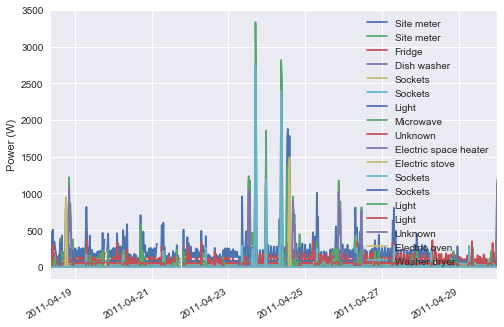

In [5]:
train_elec.plot()

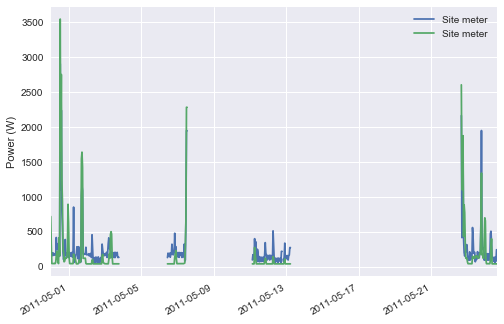

In [6]:
test_elec.mains().plot()

In [7]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [8]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [9]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 60
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!
Runtime = 5.245254039764404 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge'

In [10]:
appliance_labels = [m.label() for m in gt.columns.values]

In [11]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

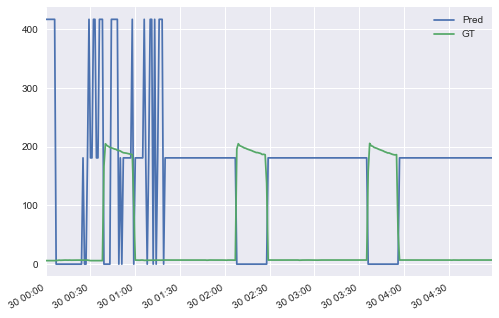

In [12]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

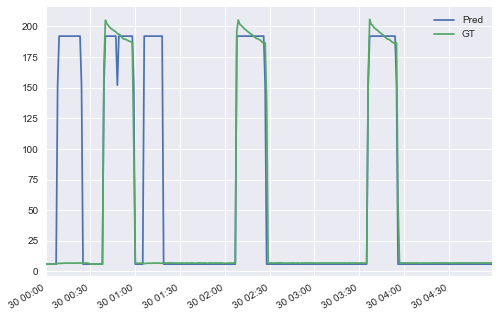

In [13]:
predictions['FHMM']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

In [14]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

,CO,FHMM
Fridge,145.904404,76.057468
Light,104.319229,60.418762
Sockets,33.882381,36.865325
Microwave,268.264465,236.889665
Dish washer,242.065033,262.823549


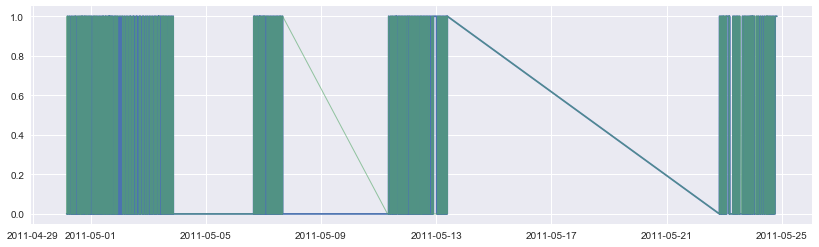

Accuracy:  0.8278767453057294
F1 Score:  0.7277573296103567
ROC AUC:  0.846178345227565


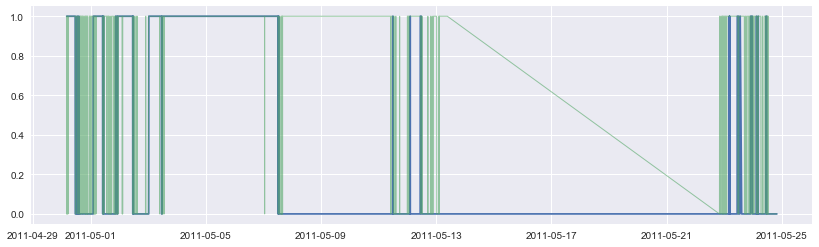

Accuracy:  0.6503771465254373
F1 Score:  0.6732168304207606
ROC AUC:  0.712977124106188


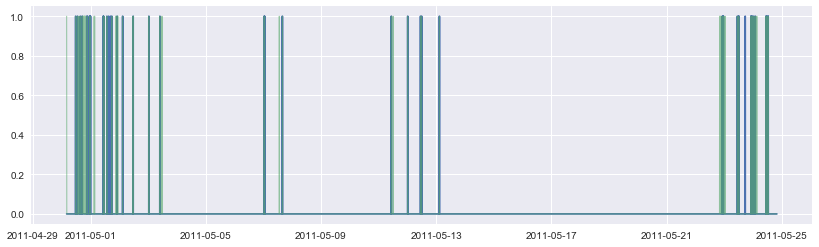

Accuracy:  0.9625260792810143
F1 Score:  0.33380884450784587
ROC AUC:  0.8085531672366063


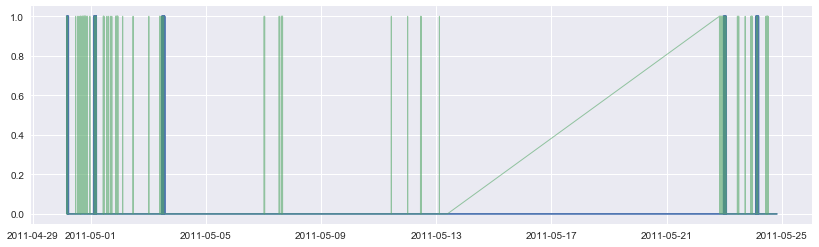

Accuracy:  0.9216016690739849
F1 Score:  0.2925416364952933
ROC AUC:  0.6697042113090291


In [16]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

appliances = ['Fridge', 'Light', 'Microwave', 'Dish washer']

for appliance in appliances:
    y_true = gt[appliance].apply(lambda x: 1 if x > 50 else 0)
    y_pred = predictions['FHMM'][appliance].apply(lambda x: 1 if x > 50 else 0)
    
    plt.figure(figsize=(14, 4))
    plt.plot(y_true)
    plt.plot(y_pred, alpha=0.6, linewidth=1)
    plt.show()
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('F1 Score: ', f1_score(y_true, y_pred))
    print('ROC AUC: ', roc_auc_score(y_true, y_pred))